## 라이브러리 불러오기

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path  # 파일 경로를 다루기 위한 클래스
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 데이터셋 불러오기

In [12]:
# 데이터가 있는 디렉토리 경로 설정
data_dir = Path('Dataset_C/')  # 'Path'클래스를 이용하여 경로 설정

# 모든 이미지의 목록을 가져옴
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
# 이미지 파일 이름에서 레이블(캡챠 텍스트) 추출
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
# 여기서 img.split("_")[-1]은 파일 이름의 마지막 부분(캡챠 문자)을 추출
# 레이블에서 고유한 문자들 추출
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

# 발견된 이미지, 레이블, 고유 문자의 수 출력
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# 학습 및 검증을 위한 배치 크기 설정
batch_size = 32

# 원하는 이미지 크기 설정
img_width = 200
img_height = 50

# 컨볼루션 블록에 의한 이미지 다운샘플링 요소
# 두 개의 컨볼루션 블록을 사용하며 각 블록은 풀링 레이어를 통해 특징을 2배 다운샘플
# 따라서 총 다운샘플링 요소는 4가 됨
downsample_factor = 4

# 데이터셋 내 캡챠의 최대 길이 설정
max_length = max([len(label) for label in labels])


Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# 레이블 확인

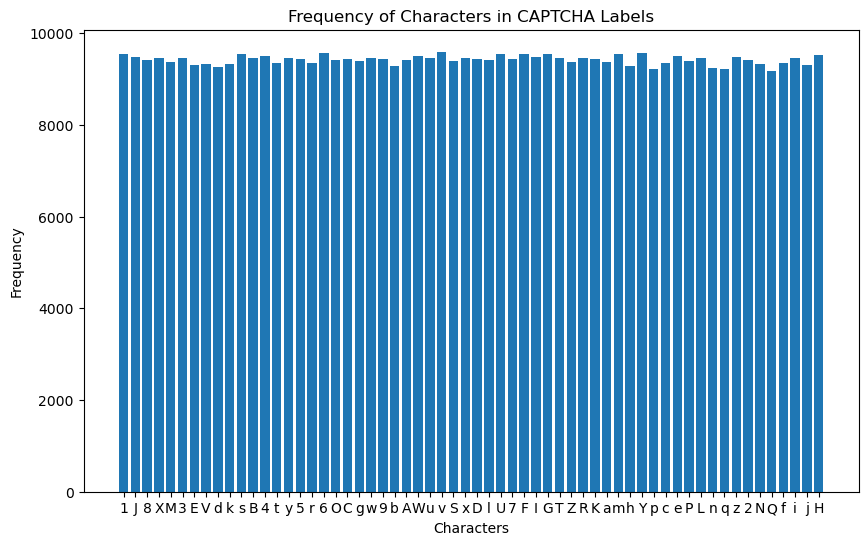

In [13]:
# 레이블의 고유 문자 분포 확인
# 문자들의 빈도를 계산
char_freq = Counter(char for label in labels for char in label)

# 문자와 빈도수를 각각 분리하여 리스트로 저장
chars = list(char_freq.keys())
freqs = list(char_freq.values())

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(chars, freqs)
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Frequency of Characters in CAPTCHA Labels')
plt.show()

## 데이터셋 전처리

In [14]:
# 문자를 정수로 매핑
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)
# 캡챠에 사용된 각각의 문자에 고유한 정수 ID를 할당

# 정수를 원래의 문자로 매핑
# 매핑된 정수 ID를 다시 원래 문자로 변환

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# 데이터셋의 인덱스를 생성
indices = np.arange(len(images))

# 인덱스를 학습 및 검증 세트로 분할
from sklearn.model_selection import train_test_split

train_indices, valid_indices = train_test_split(
    indices, train_size=0.8, random_state=42)

# 분할된 인덱스를 사용하여 이미지와 레이블을 선택
x_train = [images[i] for i in train_indices]
y_train = [labels[i] for i in train_indices]
x_valid = [images[i] for i in valid_indices]
y_valid = [labels[i] for i in valid_indices]

def encode_single_sample(img_path, label):
    # 이미지를 불러오기
    img = tf.io.read_file(img_path)

    # 이미지를 디코드하고 흑백으로 변환
    img = tf.io.decode_png(img, channels=1)

    # 이미지를 [0, 1] 범위의 float32로 변환
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 원하는 크기로 이미지를 조정
    img = tf.image.resize(img, [img_height, img_width])

    # 시간 차원이 이미지의 너비와 일치하도록 이미지를 전치
    img = tf.transpose(img, perm=[1, 0, 2])

    # 레이블의 문자를 숫자로 매핑
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    # 레이블을 패딩하여 모든 레이블이 동일한 길이를 갖도록 함
    padding_size = max_length - tf.shape(label)[0]
    padding = tf.zeros(padding_size, dtype=label.dtype)  # label과 동일한 타입의 텐서로 패딩 생성
    label = tf.concat([label, padding], axis=0) # 레이블에 패딩 추가

    # 모델이 두 개의 입력을 기대하므로 dict 형태로 반환
    return {"image": img, "label": label}

## 데이터셋 생성

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# 데이터 시각화

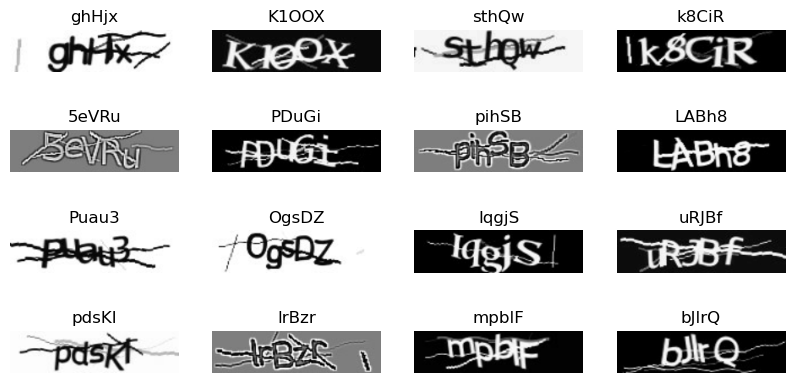

In [16]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## 모델 생성

In [17]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        # CTC 손실 함수 정의

    def call(self, y_true, y_pred):
        # 훈련 시 손실 값을 계산하고 이를 레이어에 추가
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # 테스트 시에는 계산된 예측값을 반환
        return y_pred

In [18]:
def build_model():
    # 모델에 대한 입력 정의
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 첫 번째 컨볼루션 블록
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두 번째 컨볼루션 블록
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # 두 개의 풀링 레이어를 사용하므로, 특징 맵은 4배 작아짐
    # 마지막 레이어의 필터 수는 64입니다. RNN 부분으로 넘어가기 전에 적절히 형태를 변경
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN 레이어
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # 출력 레이어
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # 각 단계에서 CTC 손실을 계산하기 위한 CTC 레이어 추가
    output = CTCLayer(name="ctc_loss")(labels, x)

    # 모델 정의
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    # 모델 컴파일 및 반환
    model.compile(optimizer=keras.optimizers.legacy.Adam())
    return model


# 모델 생성
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 batch_normalization_4 (Bat  (None, 200, 50, 32)          128       ['Conv1[0][0]']               
 chNormalization)                                                                                 
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['batch_normalizati

## 모델 훈련

In [19]:
epochs = 100
early_stopping_patience = 10
# 얼리스탑 추가
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# 모델 훈련하기
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
2827/2827 [==============================] - 554s 194ms/step - loss: 21.2457 - val_loss: 19.4973
Epoch 2/100
2827/2827 [==============================] - 476s 168ms/step - loss: 16.2467 - val_loss: 12.8353
Epoch 3/100
2827/2827 [==============================] - 468s 165ms/step - loss: 11.2590 - val_loss: 9.2402
Epoch 4/100
2827/2827 [==============================] - 468s 166ms/step - loss: 8.6254 - val_loss: 7.3696
Epoch 5/100
2827/2827 [==============================] - 468s 166ms/step - loss: 7.1044 - val_loss: 6.0820
Epoch 6/100
2827/2827 [==============================] - 466s 165ms/step - loss: 6.1485 - val_loss: 5.5454
Epoch 7/100
2827/2827 [==============================] - 467s 165ms/step - loss: 5.4779 - val_loss: 5.2564
Epoch 8/100
2827/2827 [==============================] - 465s 165ms/step - loss: 5.0796 - val_loss: 4.5925
Epoch 9/100
2827/2827 [==============================] - 460s 163ms/step - loss: 4.6940 - val_loss: 4.5134
Epoch 10/100
2827/2827 [========

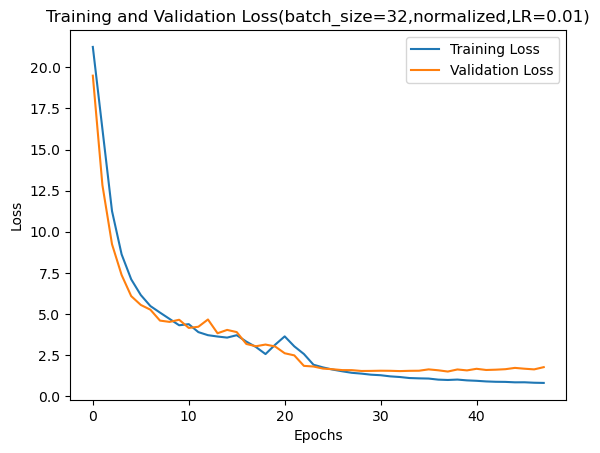

In [23]:
# 훈련 및 검증 손실 그래프 출력
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title('Training and Validation Loss(batch_size=32,normalized,LR=0.01)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

## 모델 평가

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 batch_normalization_4 (Bat  (None, 200, 50, 32)       128       
 chNormalization)                                                
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 batch_normalization_5 (Bat  (None, 100, 25, 64)       256       
 chNormalization)                                          

IndexError: index 4 is out of bounds for axis 0 with size 4

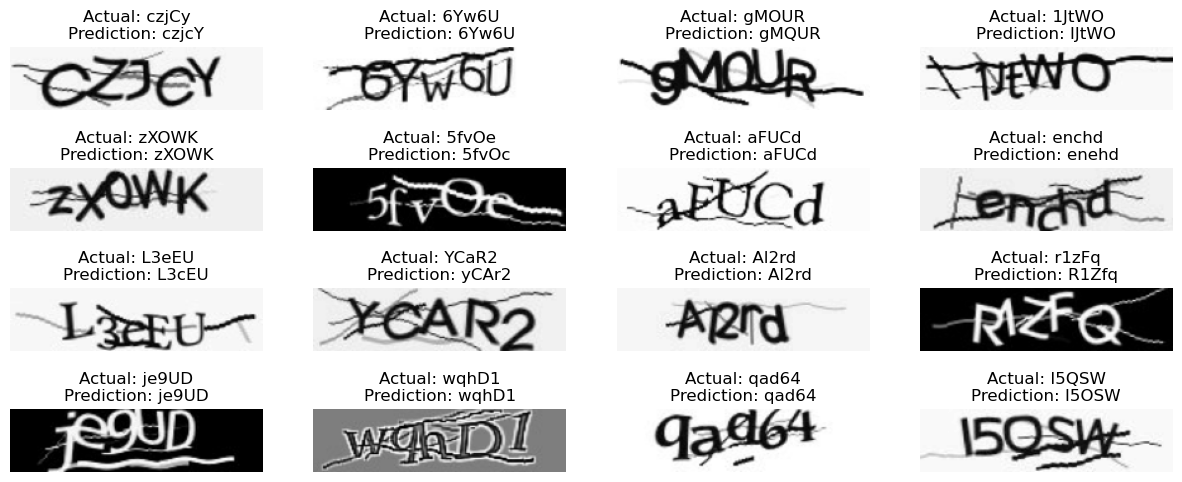

In [28]:
# 출력 레이어까지의 레이어를 추출하여 예측 모델을 구성
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# 네트워크 출력을 디코드하는 유틸리티 함수
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # 탐욕적 검색 사용. 더 복잡한 작업에는 빔 검색 사용 가능
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
              :, :max_length
              ]
    # 결과를 반복하며 텍스트를 추출
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


# 검증 샘플에서 결과 확인
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 6))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Actual: {orig_texts[i]}\nPrediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [22]:
# 모델 저장
model.save('CAPTCHA_CRNN_model(Dataset_C,batch_size=32,normalized,lr=0.01).h5')

/opt/homebrew/Caskroom/miniforge/base/envs/HUFS_ML_CAPTCHA/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
